In [1]:
import sys
sys.path.append('../lib')
from simulations import simulate_trajectory
from models import G_Maxwell, G_Kelvin_Voigt, G_fractional_Kelvin_Voigt, PSD
from analyze_data import powerspectrum,initial_guess_localy_linear_fractional_kelvin_voigt, initial_guess_maxwell, initial_guess_kelvin_voigt, initial_guess_fractional_kelvin_voigt, fit_maxwell, fit_kelvin_voigt, fit_fractional_kelvin_voigt, Laplace_NLL
import matplotlib.pyplot as plt
import numpy as np
from data_handeling import Data

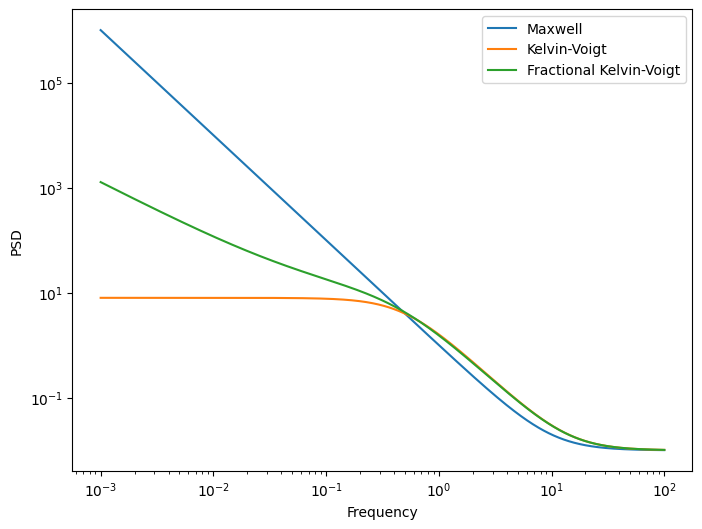

In [2]:
#plot the PSD of the idfferent models
fig, ax = plt.subplots(1,1, figsize=(8,6))
min_freq = 0.001
max_freq = 100
freq = np.logspace(np.log10(min_freq), np.log10(max_freq), 1000)
A = .5
B = 1.
alpha = .1
beta = 1
noise = 0.01
PSD_maxwell = PSD(freq, G_Maxwell, [A, B,noise])
plt.plot(freq, PSD_maxwell, label='Maxwell')
PSD_kv = PSD(freq, G_Kelvin_Voigt, [A, B,noise])
plt.plot(freq, PSD_kv, label='Kelvin-Voigt')
PSD_fkv = PSD(freq, G_fractional_Kelvin_Voigt, [A, B, alpha, beta, noise])
plt.plot(freq, PSD_fkv, label='Fractional Kelvin-Voigt')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()

In [3]:
simulation_time =int( 1/min_freq)
sampling_steps = int(simulation_time*max_freq*2)

log_weighted = True
unweighted_postfit = True

maxwell_data = Data(*simulate_trajectory(simulation_time,sampling_steps, G_Maxwell, [A, B, noise]), name='Maxwell', log_weighted=log_weighted, unweighted_postfit = unweighted_postfit)
kelvin_voit_data= Data(*simulate_trajectory(simulation_time,sampling_steps, G_Kelvin_Voigt, [A, B, noise]), name='Kelvin-Voigt', log_weighted=log_weighted, unweighted_postfit = unweighted_postfit)
fractional_kelvin_voigt_data=Data(*simulate_trajectory(simulation_time,sampling_steps, G_fractional_Kelvin_Voigt, [A, B, alpha, beta, noise]), name='Fractional Kelvin-Voigt', log_weighted=log_weighted, unweighted_postfit = unweighted_postfit)

Data_list = [maxwell_data, kelvin_voit_data, fractional_kelvin_voigt_data]

c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\models.py:15: RuntimeWarning: divide by zero encountered in divide
  psd = np.where(omega == 0, 0, -2 * kbT / omega * np.imag(1/G(omega, *G_args)) + noise)
c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\models.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1/(A /((1j * omega)) + B)
c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\models.py:9: RuntimeWarning: invalid value encountered in divide
  return 1/(A /((1j * omega)) + B)
c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\models.py:15: RuntimeWarning: invalid value encountered in divide
  psd = np.where(omega == 0, 0, -2 * kbT / omega * np.imag(1/G(omega, *G_args)) + noise)
c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\models.py:15: RuntimeWarning: invalid value encountered in multiply
  psd = np.where(omega == 0, 0, -2 * kbT / omega * np.imag(1/G(omega, *G_args)) + noise)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


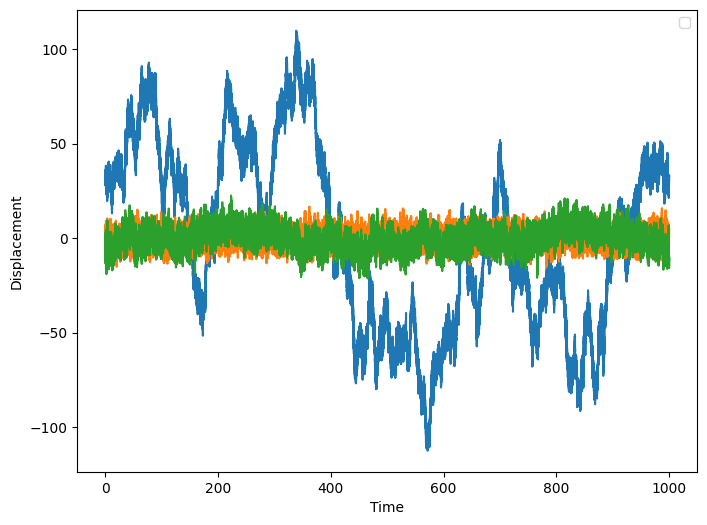

In [4]:
#plot the trajectory    
fig, ax = plt.subplots(1,1, figsize=(8,6))
for data in Data_list:
    data.plot_x(ax)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.show()

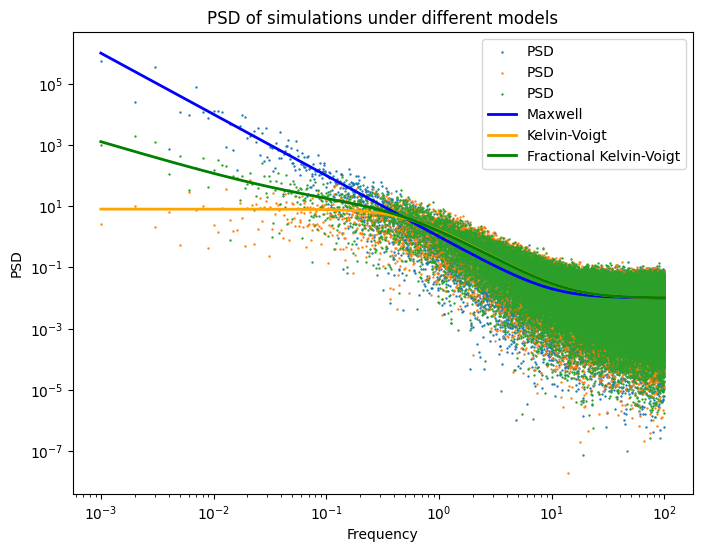

In [5]:
for data in Data_list:
    data.create_PSD()
#plot the PSD of the idfferent models
point_size = .5
fig, ax = plt.subplots(1,1, figsize=(8,6))
for data in Data_list:
    data.plot_psd(ax)
plt.plot(freq, PSD_maxwell, color = "blue",linewidth = 2, label='Maxwell')
plt.plot(freq, PSD_kv, color = "orange",linewidth = 2, label='Kelvin-Voigt')
plt.plot(freq, PSD_fkv, color = "green",linewidth = 2, label='Fractional Kelvin-Voigt')
plt.title('PSD of simulations under different models')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.show()


In [6]:
#make all the fits for all the data
for data in Data_list:
    data.create_NLL_maxwell()
    data.create_NLL_kelvin_voigt()
    data.create_NLL_fractional_kelvin_voigt()

c:\Users\jschulz\Desktop\Spectral-Noise-Cleaning\demos\../lib\analyze_data.py:36: RuntimeWarning: invalid value encountered in log
  Loss = y_data / y_model + np.log(y_model)


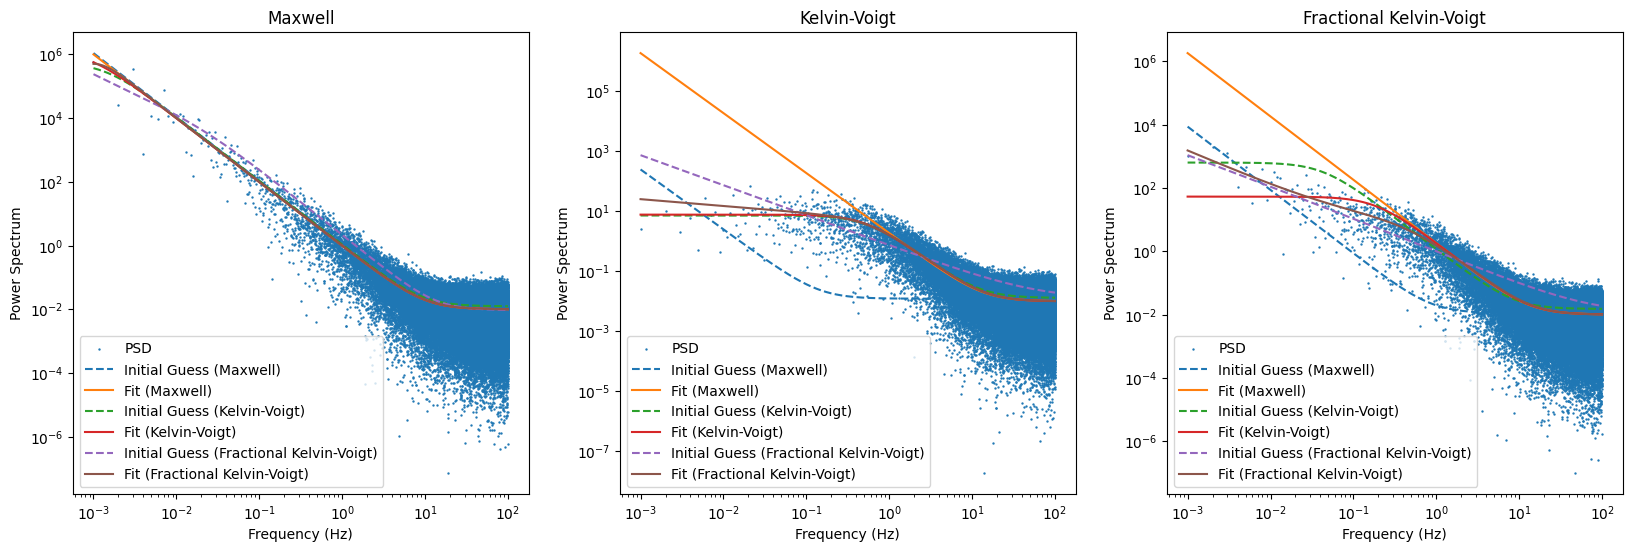

In [7]:
#make one plot for each data in a row. In each plot, plot the data and the fits

fig, ax = plt.subplots(1,3, figsize=(20,6))
data_names = ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt']
for i, data in enumerate(Data_list):
    #make title
    ax[i].set_title(data_names[i])
    data.plot_psd(ax[i])
    

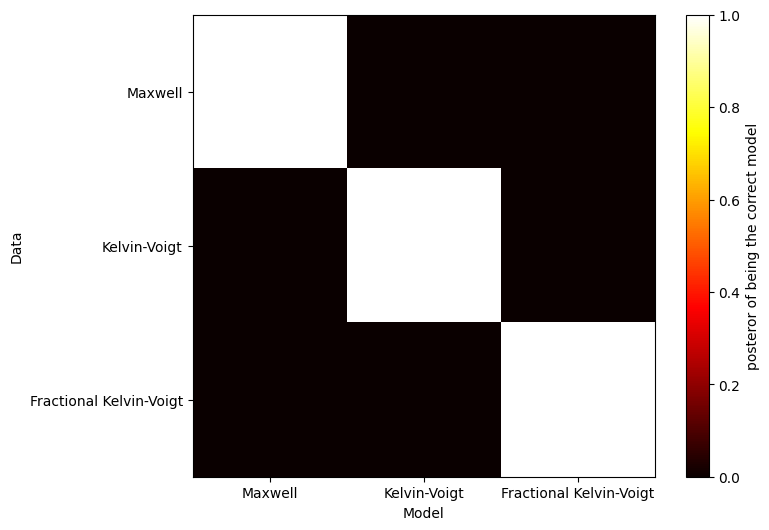

In [8]:
#make a matrix colormap with data on the one axis and models on the other axis. In each cell, plot the NLL of the model for the data
posteror_matrix = np.zeros((len(Data_list),3))
for i, data in enumerate(Data_list):
    data.bayesian_update()
    posteror_matrix[i,0] = data.posterior_maxwell
    posteror_matrix[i,1] = data.posterior_kelvin_voigt
    posteror_matrix[i,2] = data.posterior_fractional_kelvin_voigt

fig, ax = plt.subplots(1,1, figsize=(8,6))
im = ax.imshow(posteror_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(im, ax=ax, label='posteror of being the correct model')
plt.xlabel('Model')
plt.ylabel('Data')
plt.xticks([0,1,2], ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
plt.yticks([0,1,2], ['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
plt.show()


In [9]:
# print the fit parameters and the posteror of the models
for data in Data_list:
    print(data.name)
    print('Maxwell:', data.posterior_maxwell)
    print('Kelvin-Voigt:', data.posterior_kelvin_voigt)
    print('Fractional Kelvin-Voigt:', data.posterior_fractional_kelvin_voigt)
    print('Maxwell:', data.fit_maxwell.x)
    print('Kelvin-Voigt:', data.fit_kelvin_voigt.x)
    print('Fractional Kelvin-Voigt:', data.fit_fractional_kelvin_voigt.x)
    print('')

Maxwell
Maxwell: 0.9968476340881185
Kelvin-Voigt: 0.003152306288912
Fractional Kelvin-Voigt: 5.962296941543914e-08
Maxwell: [0.5060869  1.00570905 0.00994524]
Kelvin-Voigt: [1.16929235e-07 1.97590727e+00 9.94522329e-03]
Fractional Kelvin-Voigt: [-2.18953559  4.15993576  0.86470099  0.93071497  0.00992522]

Kelvin-Voigt
Maxwell: 0.0
Kelvin-Voigt: 0.9999897894047652
Fractional Kelvin-Voigt: 1.021059523473839e-05
Maxwell: [9.08793092e-01 4.33532124e+07 1.01586830e-02]
Kelvin-Voigt: [0.53126082 1.00958014 0.01005024]
Fractional Kelvin-Voigt: [ 5.38655847e-01 -2.84174808e-01 -2.17445776e-04 -9.92742077e-01
  1.00584206e-02]

Fractional Kelvin-Voigt
Maxwell: 3.086088870840778e-149
Kelvin-Voigt: 1.0
Fractional Kelvin-Voigt: 1.6014016949501359e-103
Maxwell: [ 9.12466960e-01 -2.20939134e+01  1.02127763e-02]
Kelvin-Voigt: [0.24255173 1.05411857 0.01016277]
Fractional Kelvin-Voigt: [ 2.08062704 -0.92178372  0.53777316 -0.11690081  0.00912162]



In [11]:
# print the fit parameters and the posteror of the models
for data in Data_list:
    print(data.name)
    print('Maxwell:', data.posterior_maxwell)
    print('Kelvin-Voigt:', data.posterior_kelvin_voigt)
    print('Fractional Kelvin-Voigt:', data.posterior_fractional_kelvin_voigt)
    print('Maxwell:', data.fit_maxwell.x)
    print('Kelvin-Voigt:', data.fit_kelvin_voigt.x)
    print('Fractional Kelvin-Voigt:', data.fit_fractional_kelvin_voigt.x)
    print('')

Maxwell
Maxwell: 2.9328790266872464e-86
Kelvin-Voigt: 1.0
Fractional Kelvin-Voigt: 0.0
Maxwell: [0.41054164 0.87218444 0.01059787]
Kelvin-Voigt: [0.00654883 1.95267495 0.0099429 ]
Fractional Kelvin-Voigt: [ 8.08823122e-04  1.99723731e+00 -2.65437576e-01  9.54187603e-01
  1.14128257e-02]

Kelvin-Voigt
Maxwell: 0.0
Kelvin-Voigt: 1.0
Fractional Kelvin-Voigt: 0.0
Maxwell: [ 7.59907202e-06 -2.33722833e+02  3.49951580e+00]
Kelvin-Voigt: [0.48956312 1.01044452 0.00998253]
Fractional Kelvin-Voigt: [ 3.93469549e-03  7.02495723e-05 -8.85721527e-04  1.05551240e-01
 -4.46536871e-04]

Fractional Kelvin-Voigt
Maxwell: 0.0
Kelvin-Voigt: 0.0
Fractional Kelvin-Voigt: 1.0
Maxwell: [ 1.91044834e-01 -4.30670734e+01  3.02242712e-02]
Kelvin-Voigt: [0.06797463 2.15423022 0.01361697]
Fractional Kelvin-Voigt: [0.60642828 0.92128527 0.13773952 1.07530164 0.01033771]



In [14]:
from analyze_data import  fit_maxwell, fit_kelvin_voigt, fit_fractional_kelvin_voigt

In [15]:
#refit all the fits, but with no log weighting
for data in Data_list:
    data.fit_maxwell = fit_maxwell(data.frequencies, data.PSD, data.fit_maxwell.x, log_weighted=False)
    data.fit_kelvin_voigt = fit_kelvin_voigt(data.frequencies, data.PSD, data.fit_kelvin_voigt.x, log_weighted=False)
    data.fit_fractional_kelvin_voigt = fit_fractional_kelvin_voigt(data.frequencies, data.PSD, data.fit_fractional_kelvin_voigt.x, log_weighted=False)



In [10]:
import numpy as np
import pandas as pd


# Assuming these are defined: G_Maxwell, G_Kelvin_Voigt, G_fractional_Kelvin_Voigt
# and Data_list contains datasets with attributes like .frequencies, .PSD, .fit_maxwell.x, etc.

df_rows = []

for data in Data_list:
    # Assuming priors are defined for each model
    priors = {"G_Maxwell": 1.0/3, "G_Kelvin_Voigt": 1.0/3, "G_fractional_Kelvin_Voigt": 1.0/3}
    
    for weighted in [False, True]:
        n_eff = len(data.PSD) if not weighted else np.sum(1/np.arange(1, len(data.PSD)+1))
        fitparams = [data.fit_maxwell.x, data.fit_kelvin_voigt.x, data.fit_fractional_kelvin_voigt.x]
        models = [G_Maxwell, G_Kelvin_Voigt, G_fractional_Kelvin_Voigt]
        k_list = [2,3,5]
        BICs = []
        
        for fit_param, G, k in zip(fitparams, models,k_list):
            target_function = lambda x, *params: PSD(x, G, params)
            NLL = Laplace_NLL(fit_param, data.frequencies, data.PSD, target_function, weighted)
            BIC = k * np.log(n_eff) + 2 * NLL
            BICs.append(BIC)
        
        min_BIC = min(BICs)
        posteriors = []
        
        for BIC, G in zip(BICs, models):
            adjusted_BIC = BIC - min_BIC
            posterior = np.exp(-adjusted_BIC / 2) * priors[G.__name__]
            posteriors.append(posterior)
        
        #normalize posteriors
        posteriors = posteriors / np.sum(posteriors)
        
        for model_name, posterior in zip(["G_Maxwell", "G_Kelvin_Voigt", "G_fractional_Kelvin_Voigt"], posteriors):
            df_rows.append({
                "Data Name": data.name,
                "Model": model_name,
                "Weighted": weighted,
                "Posterior": posterior
            })

df = pd.DataFrame(df_rows)


In [11]:
# Assuming df is the DataFrame created from the previous step

# Separate the DataFrame into two based on the 'Weighted' column: one for weighted and one for unweighted
df_weighted = df[df['Weighted'] == True].reset_index(drop=True)
df_unweighted = df[df['Weighted'] == False].reset_index(drop=True)

# Assuming the order of 'Data Name' is consistent across weighted and unweighted, 
# and the order of 'Model' is consistent as well within each 'Data Name' grouping

# Extract posterior matrices
# The shape of the matrices depends on the number of unique 'Data Name' entries and the number of models
num_data = len(df['Data Name'].unique())
num_models = len(df['Model'].unique())

# Initialize matrices
posterior_matrix_weighted = np.zeros((num_data, num_models))
posterior_matrix_unweighted = np.zeros((num_data, num_models))

# Populate the matrices
for i, data_name in enumerate(df['Data Name'].unique()):
    for j, model_name in enumerate(df['Model'].unique()):
        posterior_matrix_weighted[i, j] = df_weighted.loc[(df_weighted['Data Name'] == data_name) & 
                                                           (df_weighted['Model'] == model_name), 'Posterior'].values[0]
        posterior_matrix_unweighted[i, j] = df_unweighted.loc[(df_unweighted['Data Name'] == data_name) & 
                                                               (df_unweighted['Model'] == model_name), 'Posterior'].values[0]


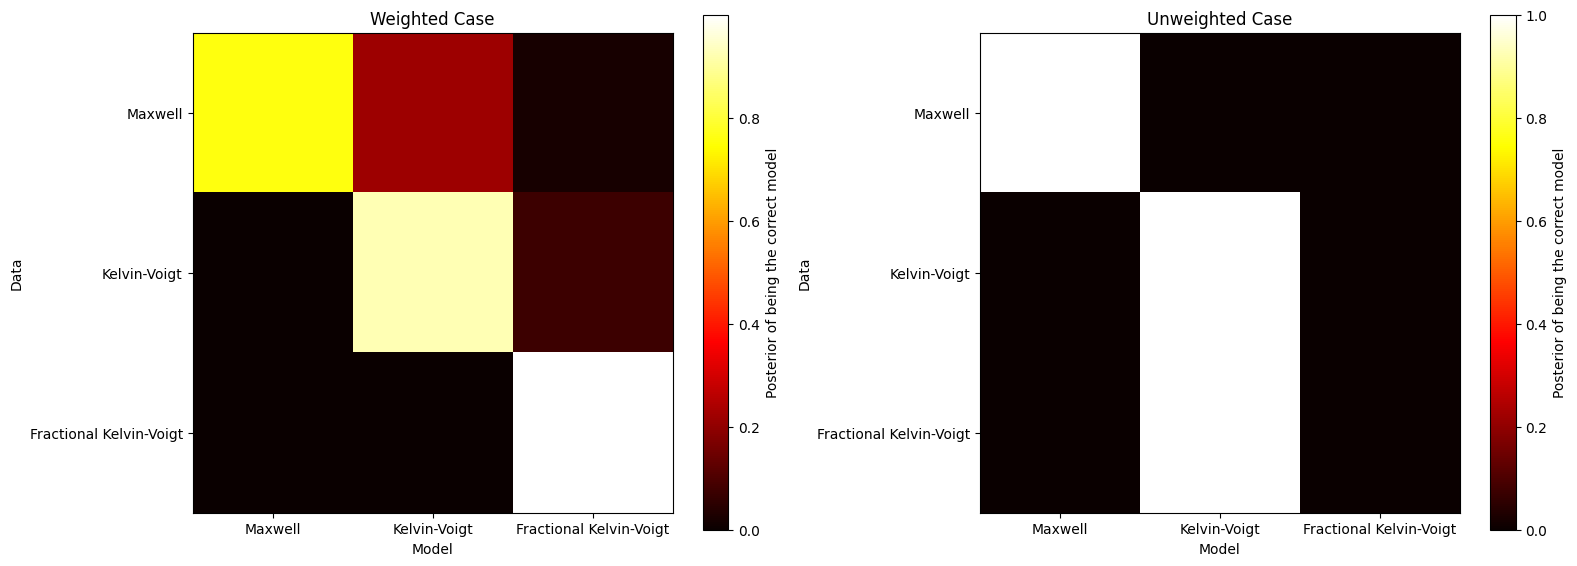

In [12]:
import numpy as np
import matplotlib.pyplot as plt



fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Weighted case
im_weighted = axs[0].imshow(posterior_matrix_weighted, cmap='hot', interpolation='nearest')
fig.colorbar(im_weighted, ax=axs[0], label='Posterior of being the correct model')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('Data')
axs[0].set_title('Weighted Case')
axs[0].set_xticks([0, 1, 2])
axs[0].set_yticks(range(len(Data_list)))
axs[0].set_xticklabels(['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
axs[0].set_yticklabels([data.name for data in Data_list])

# Unweighted case
im_unweighted = axs[1].imshow(posterior_matrix_unweighted, cmap='hot', interpolation='nearest')
fig.colorbar(im_unweighted, ax=axs[1], label='Posterior of being the correct model')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('Data')
axs[1].set_title('Unweighted Case')
axs[1].set_xticks([0, 1, 2])
axs[1].set_yticks(range(len(Data_list)))
axs[1].set_xticklabels(['Maxwell', 'Kelvin-Voigt', 'Fractional Kelvin-Voigt'])
axs[1].set_yticklabels([data.name for data in Data_list])

plt.tight_layout()
plt.show()

